# Data exploration

## Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import random
from shapely import geometry
import rasterio
from math import floor
import matplotlib.patches as patches
import cv2 as cv

IMAGES_RGB_PATH = "data/AOI_3_Paris_Train/RGB-PanSharpen/"
COMMON_NAME_RGB = "RGB-PanSharpen_AOI_3_Paris_img"

GEOJSONS_PATH = "data/AOI_3_Paris_Train/geojson/buildings/"
COMMON_NAME_GEOJSONS = "buildings_AOI_3_Paris_img"

## Useful functions

In [2]:
def get_random_image():
    images_filenames = os.listdir(IMAGES_RGB_PATH)
    random_image_path = IMAGES_RGB_PATH + random.choice(images_filenames)
    index_image = random_image_path[len(IMAGES_RGB_PATH) + len(COMMON_NAME_RGB):-4]
    geojson_path = GEOJSONS_PATH + COMMON_NAME_GEOJSONS + index_image + ".geojson"
    return random_image_path, geojson_path
    

def gdal_to_rgb(ds):
    img = ds.ReadAsArray()
    img = np.transpose(img, (1, 2, 0))
    img = img.astype(np.float32)

    min_vals = np.min(img, axis=(0, 1))
    max_vals = np.max(img, axis=(0, 1))

    normalized_image = (img - min_vals) / (max_vals - min_vals)

    return (normalized_image * 255).astype(np.uint8)

def display_image(image_path):
    ds = gdal.Open(image_path)
    img = gdal_to_rgb(ds)
    plt.imshow(img)
    plt.axis('off')
    
    
def object_features(feature, ffa, aff):    
    poly = geometry.shape(feature['geometry'])
    center = poly.centroid
    x_center, y_center = ffa * (center.x, center.y)
    bbox = poly.bounds
    width = (bbox[2] - bbox[0]) // aff[0]
    height = (bbox[3] - bbox[1]) // -aff[4]
    out = ('obj_class', floor(x_center), floor(y_center), width, height)
    return out

# reference: https://gist.github.com/avanetten/534e6f341b0670be2ea74ce39d68226a#file-geojson_to_pixel_arr-py

from osgeo import gdal, osr, ogr
def latlon2pixel(lat, lon, input_raster='', targetsr='', geom_transform=''):
    # type: (object, object, object, object, object) -> object

    sourcesr = osr.SpatialReference()
    sourcesr.ImportFromEPSG(4326)

    geom = ogr.Geometry(ogr.wkbPoint)
    geom.AddPoint(lon, lat)

    if targetsr == '':
        src_raster = gdal.Open(input_raster)
        targetsr = osr.SpatialReference()
        targetsr.ImportFromWkt(src_raster.GetProjectionRef())
    coord_trans = osr.CoordinateTransformation(sourcesr, targetsr)
    if geom_transform == '':
        src_raster = gdal.Open(input_raster)
        transform = src_raster.GetGeoTransform()
    else:
        transform = geom_transform

    x_origin = transform[0]
    # print(x_origin)
    y_origin = transform[3]
    # print(y_origin)
    pixel_width = transform[1]
    # print(pixel_width)
    pixel_height = transform[5]
    # print(pixel_height)
    geom.Transform(coord_trans)
    # print(geom.GetPoint())
    x_pix = (geom.GetPoint()[0] - x_origin) / pixel_width
    y_pix = (geom.GetPoint()[1] - y_origin) / pixel_height

    return (x_pix, y_pix)


def geojson_to_pixel_arr(raster_file, geojson_file, pixel_ints=True,
                       verbose=False):
    '''
    Tranform geojson file into array of points in pixel (and latlon) coords
    pixel_ints = 1 sets pixel coords as integers
    '''
    
    # load geojson file
    with open(geojson_file) as f:
        geojson_data = json.load(f)

    # load raster file and get geo transforms
    src_raster = gdal.Open(raster_file)
    targetsr = osr.SpatialReference()
    targetsr.ImportFromWkt(src_raster.GetProjectionRef())
        
    geom_transform = src_raster.GetGeoTransform()
    
    # get latlon coords
    latlons = []
    types = []
    for feature in geojson_data['features']:
        coords_tmp = feature['geometry']['coordinates'][0]
        type_tmp = feature['geometry']['type']
        if verbose: 
            print("features:", feature.keys())
            print("geometry:features:", feature['geometry'].keys())

            #print "feature['geometry']['coordinates'][0]", z
        latlons.append(coords_tmp)
        types.append(type_tmp)
        #print feature['geometry']['type']
    
    # convert latlons to pixel coords
    pixel_coords = []
    latlon_coords = []
    for i, (poly_type, poly0) in enumerate(zip(types, latlons)):
        
        if poly_type.upper() == 'MULTIPOLYGON':
            #print "oops, multipolygon"
            for poly in poly0:
                poly=np.array(poly)
                if verbose:
                    print("poly.shape:", poly.shape)
                    
                # account for nested arrays
                if len(poly.shape) == 3 and poly.shape[0] == 1:
                    poly = poly[0]
                    
                poly_list_pix = []
                poly_list_latlon = []
                if verbose: 
                    print("poly", poly)
                for coord in poly:
                    if verbose: 
                        print("coord:", coord)
                    lon, lat, z = coord 
                    px, py = latlon2pixel(lat, lon, input_raster=src_raster,
                                         targetsr=targetsr, 
                                         geom_transform=geom_transform)
                    poly_list_pix.append([px, py])
                    if verbose:
                        print("px, py", px, py)
                    poly_list_latlon.append([lat, lon])
                
                if pixel_ints:
                    ptmp = np.rint(poly_list_pix).astype(int)
                else:
                    ptmp = poly_list_pix
                pixel_coords.append(ptmp)
                latlon_coords.append(poly_list_latlon)            

        elif poly_type.upper() == 'POLYGON':
            poly=np.array(poly0)
            if verbose:
                print("poly.shape:", poly.shape)
                
            # account for nested arrays
            if len(poly.shape) == 3 and poly.shape[0] == 1:
                poly = poly[0]
                
            poly_list_pix = []
            poly_list_latlon = []
            if verbose: 
                print("poly", poly)
            for coord in poly:
                if verbose: 
                    print("coord:", coord)
                lon, lat, z = coord 
                px, py = latlon2pixel(lat, lon, input_raster=src_raster,
                                     targetsr=targetsr, 
                                     geom_transform=geom_transform)
                poly_list_pix.append([px, py])
                if verbose:
                    print("px, py", px, py)
                poly_list_latlon.append([lat, lon])
            
            if pixel_ints:
                ptmp = np.rint(poly_list_pix).astype(int)
            else:
                ptmp = poly_list_pix
            pixel_coords.append(ptmp)
            latlon_coords.append(poly_list_latlon)
            
        else:
            print("Unknown shape type in coords_arr_from_geojson()")
            return
            
    return pixel_coords, latlon_coords

## Dataset exploring

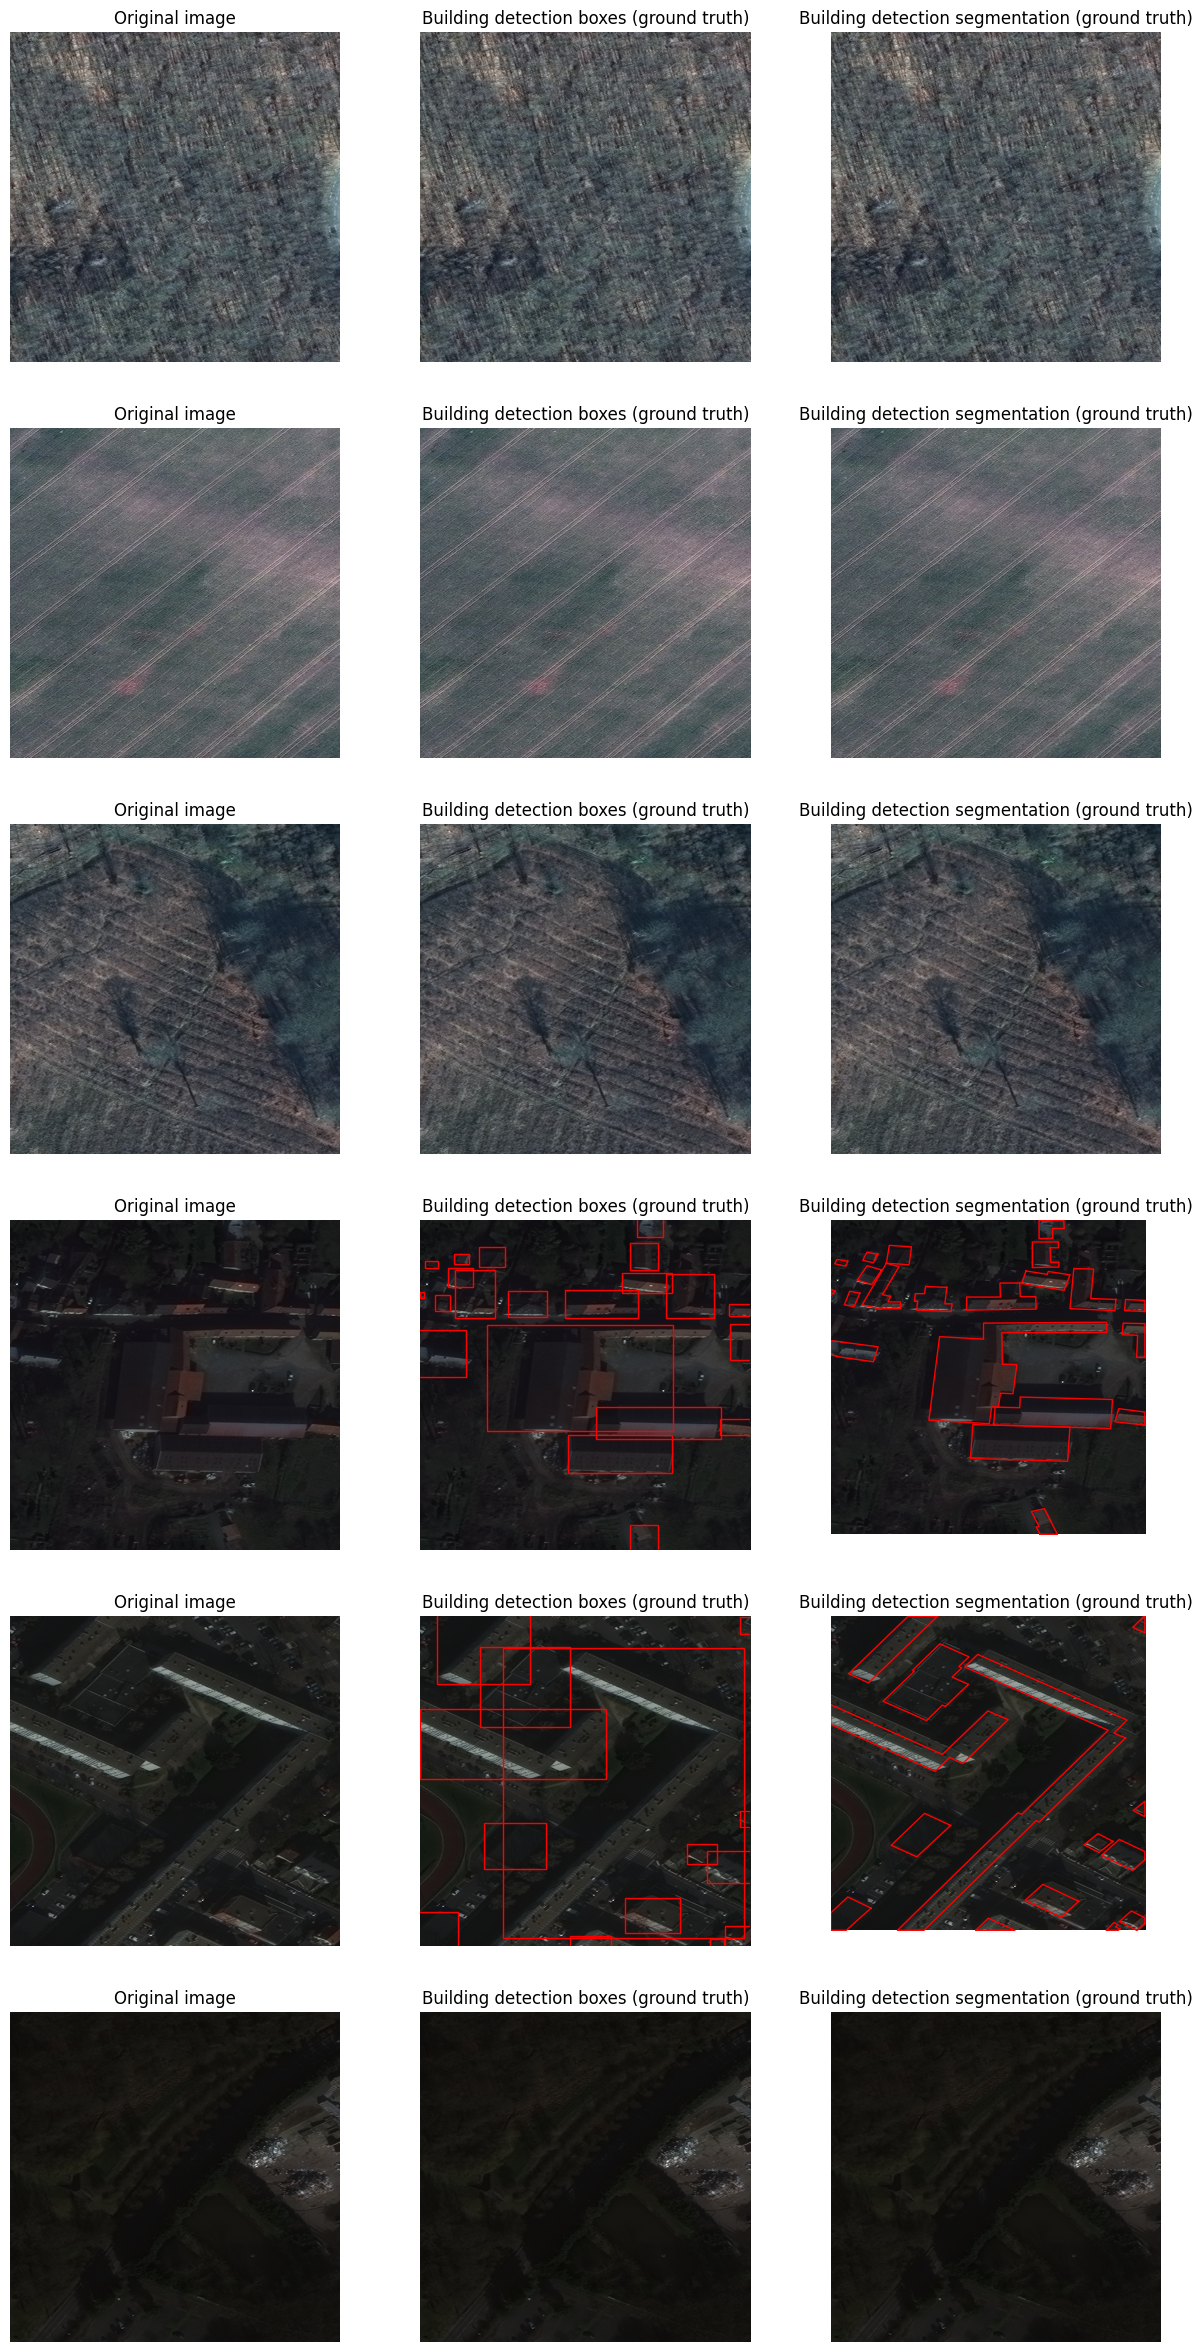

In [3]:
NUM_EXAMPLES = 6

plt.figure(figsize=(15, 30))
grid_spec = plt.GridSpec(NUM_EXAMPLES, 3, width_ratios=[1, 1, 1])
images_random = [get_random_image() for i in range(NUM_EXAMPLES)]

for i, (image_path, geo_file) in enumerate(images_random):
    img = gdal_to_rgb(gdal.Open(image_path))
    
    # FIRST PLOT
    ax1 = plt.subplot(grid_spec[i, 0])
    ax1.set_title('Original image')
    display_image(image_path)
    
    # SECOND PLOT
    ax2 = plt.subplot(grid_spec[i, 1])
    with open(geo_file) as src:
        fc = json.load(src)

    with rasterio.open(image_path) as src:
        aff = src.transform
    
    ffa = ~aff
    
    bb_list = [object_features(feat, ffa, aff) for feat in fc['features']]
    
    ax2.imshow(img)
    ax2.set_title('Building detection boxes (ground truth)')
    ax2.axis('off')
    
    for bb in bb_list:
        obj_class, x_center, y_center, width, height = bb
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        
    # THIRD PLOT
    ax3 = plt.subplot(grid_spec[i, 2])
    ax3.set_title('Building detection segmentation (ground truth)')
    display_image(image_path)
    geo_data = geojson_to_pixel_arr(image_path, geo_file, pixel_ints=True,
                                    verbose=False)

    geo_data_pix_coords = geo_data[0]
    
    for polygon in geo_data_pix_coords:
        x_coords = polygon[:, 0]
        y_coords = polygon[:, 1]
        ax3.plot(x_coords, y_coords, 'r-', linewidth=1)
plt.show()

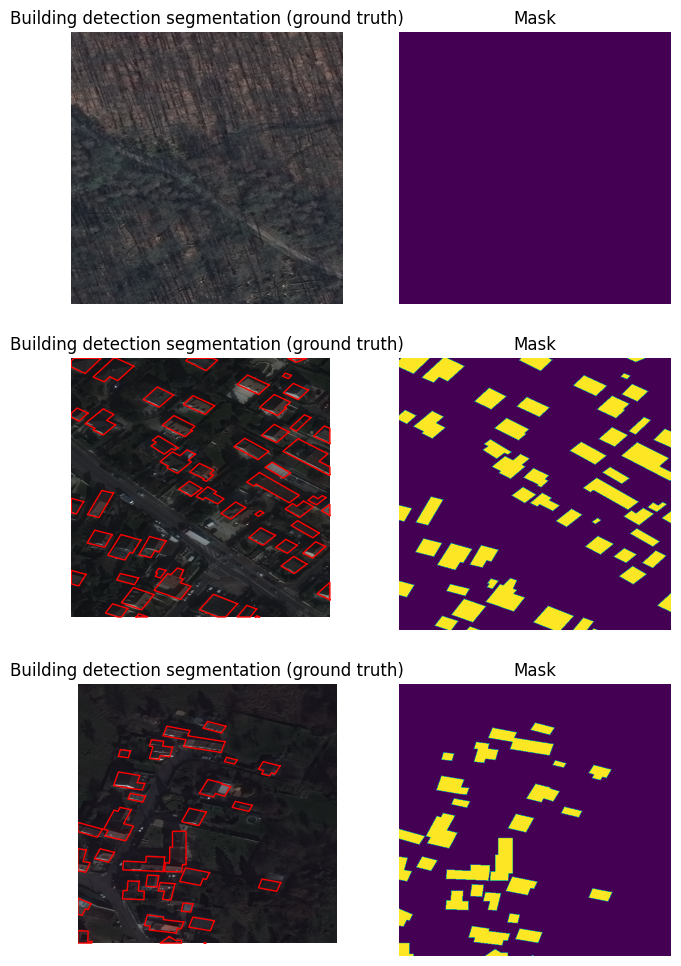

In [5]:
import skimage as ski

NUM_EXAMPLES = 3

plt.figure(figsize=(12, 12))
grid_spec = plt.GridSpec(NUM_EXAMPLES, 3, width_ratios=[1, 1, 1])
images_random = [get_random_image() for i in range(NUM_EXAMPLES)]

for i, (image_path, geo_file) in enumerate(images_random):  
    ax0 = plt.subplot(grid_spec[i, 0])
    ax0.set_title('Building detection segmentation (ground truth)')
    display_image(image_path)
    geo_data = geojson_to_pixel_arr(image_path, geo_file, pixel_ints=True,
                                    verbose=False)

    geo_data_pix_coords = geo_data[0]
    
    for polygon in geo_data_pix_coords:
        x_coords = polygon[:, 0]
        y_coords = polygon[:, 1]
        ax0.plot(x_coords, y_coords, 'r-', linewidth=1)

    ax1 = plt.subplot(grid_spec[i, 1])
    ax1.set_title('Mask')
    
    
    ds = gdal.Open(image_path)
    img = gdal_to_rgb(ds)
    mask = np.zeros(shape=(img.shape[0], img.shape[1]), dtype=np.uint8)
        
    geo_data = geojson_to_pixel_arr(image_path, geo_file, pixel_ints=True,
                                    verbose=False)

    for polygon in geo_data[0]:   
        polygon = polygon -1
        rr, cc = ski.draw.polygon(np.array(polygon)[:, 0], np.array(polygon)[:, 1])
        mask[cc, rr] = 1
    plt.imshow(mask)
    plt.axis('off')
    
plt.show()

## Create label images

In [7]:
TRAIN_IMAGES_PATH = "data/AOI_3_Paris_Train/"

TRAIN_IMAGES_RGB_PATH = "data/AOI_3_Paris_Train/RGB-PanSharpen/"
TEST_IMAGES_RGB_PATH = "data/AOI_3_Paris_Test_public/RGB-PanSharpen/"

MASK_FOLDER_NAME = "masks/"
COMMON_NAME_RGB = "RGB-PanSharpen_AOI_3_Paris_img"
ORIGINAL_SHAPE = (650, 650)
RESIZE_TO = (256, 256)

In [8]:
# create label images (masks)

def get_mask_image(base_path, filename):
    index_image = filename[len(COMMON_NAME_RGB):-4]
    geojson_path = base_path + "geojson/buildings/buildings_AOI_3_Paris_img" + index_image + ".geojson"
    mask = np.zeros(shape=ORIGINAL_SHAPE, dtype=np.uint8)
    geo_data = geojson_to_pixel_arr(base_path + "RGB-PanSharpen/" + filename, geojson_path, pixel_ints=True, verbose=False)
    
    for polygon in geo_data[0]:   
        polygon = polygon -1
        rr, cc = ski.draw.polygon(np.array(polygon)[:, 0], np.array(polygon)[:, 1])
        mask[cc, rr] = 255
    return mask

if not os.path.exists(TRAIN_IMAGES_PATH + MASK_FOLDER_NAME):
    os.makedirs(TRAIN_IMAGES_PATH + MASK_FOLDER_NAME)

train_images_filenames = os.listdir(TRAIN_IMAGES_PATH + "RGB-PanSharpen")
for filename in train_images_filenames:
    mask = get_mask_image(TRAIN_IMAGES_PATH, filename)
    cv.imwrite(TRAIN_IMAGES_PATH + MASK_FOLDER_NAME + "/" + filename, mask)

In [9]:
def load_dataset(image_dir, mask_dir):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.tif'):
            ds = gdal.Open(os.path.join(image_dir, filename))
            img = gdal_to_rgb(ds)
            img = cv.resize(img, RESIZE_TO)
            img = img / 255.0
            images.append(img)

            mask_filename = os.path.join(mask_dir, filename)
            mask = cv.imread(mask_filename, cv.IMREAD_UNCHANGED)
            mask = cv.resize(mask, RESIZE_TO)
            _, mask = cv.threshold(mask, 128, 255, cv.THRESH_BINARY)

            mask = mask / 255.0
            masks.append(mask)

    X_train = np.array(images)
    y_train = np.array(masks)

    X_train = X_train.astype(np.float32)
    y_train = y_train.astype(np.float32)

    y_train = np.expand_dims(y_train, axis=-1)
    return X_train, y_train

In [10]:
image_dir = TRAIN_IMAGES_PATH + "RGB-PanSharpen"
mask_dir = TRAIN_IMAGES_PATH + MASK_FOLDER_NAME
X_train, y_train = load_dataset(image_dir, mask_dir)

## UNET CNN

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
input_shape = (256, 256, 3)

X_train_sample = X_train[:10]
y_train_sample = y_train[:10]

# def unet(input_size=(256, 256, 3)):
#     inputs = tf.keras.Input(input_size)

#     conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)

#     up1 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
#     concat1 = layers.Concatenate()([up1, conv2])
#     conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat1)

#     up2 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
#     concat2 = layers.Concatenate()([up2, conv1])
#     conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat2)

#     output = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

#     return models.Model(inputs, output)
def unet_original(input_size=(256, 256, 1)):
    inputs = tf.keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    concat6 = layers.Concatenate()([up6, drop4])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = layers.Concatenate()([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = layers.Concatenate()([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    return models.Model(inputs, outputs)


model = unet_original(input_size=input_shape)
model.compile(optimizer=Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

model.fit(X_train_sample, y_train_sample, batch_size=64, epochs=2, verbose=10)

Epoch 1/2
Epoch 2/2


In [12]:
prediction = model.predict(np.expand_dims(X_train[-3], axis=0))

threshold = 0.5 
binary_mask = (prediction > threshold).astype(np.uint8)

cv.imshow("Threshold Binary Inverse", binary_mask[0]*255)
cv.waitKey(0)
cv.destroyAllWindows()

1/1 [==============================] - 2s 2s/step
